# Imports and paths set-up

In [ ]:
from __future__ import annotations

from matplotlib import pyplot as plt, cm
from PIL import Image, ImageOps
from scipy.ndimage import gaussian_filter
from torch.optim import SGD
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm

import numpy as np
import os,os.path
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import random

%matplotlib inline

In [ ]:
################################### If you are using google colab, uncomment the following lines ###################################
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#################################### If working on colab ####################################
csv_file_path ="/content/drive/MyDrive/Createch/Pool_Project/.dataset/coords.csv"
data_path ="/content/drive/MyDrive/Createch/Pool_Project/.dataset/images/"

#################################### If working on local machine ####################################
# csv_file_path = "./.dataset/coords.csv"
# data_path = "./.dataset/images/"

# Dataset building

### Transforms

The transforms are applied to the images and the masks. The images are normalized and the masks are converted to tensors.

In [ ]:
class ToTen(object):
    """Convert PIL image and numpy ndarray in sample to Tensors."""

    def __call__(self, sample : dict) -> tuple[torch.tensor, torch.tensor] :
        image, masks = sample['image'], sample['target']
        transform = T.ToTensor()
        masks_to_tensors = torch.from_numpy(masks)
        masks_to_tensors = torch.unsqueeze(masks_to_tensors, dim = 0)
        image = transform(image)
        # This is a test of normalizing the image 
        image = nn.functional.normalize(image)
        return {'image': image,
                'target': masks_to_tensors}

    @property
    def get_name(self) -> str:
      return "ToTensor"

### Dataset class

In [ ]:
class PoolImageDatasetSimplest(Dataset):
  '''A class that generates a dataset of images and their corresponding target'''
  global x_min,x_max,y_min,y_max, train_prop

  #Dimensions of my pool
  width , height = 1.900, 0.956
  x_min,x_max = -(width/2),width/2
  y_min,y_max = -(height/2),height/2
  train_prop = 0.75

  def __init__(
      self,
      transforms = None,
      csv_file_path : str = './coords.csv',
      data_path : str = "./images/",
      train : bool = True
      ) -> None:
      

    super().__init__()
    self.labels = pd.read_csv(csv_file_path)
    self.images_path = data_path
    self.transforms = transforms
    #define the resolution of the image in order to do the origine translation
    self.image_width, self.image_height = Image.open(data_path+"0.png").size
    # calling the cleaning function that includes mapping and translation of x and y
    self._clean_values()
    self.train = train
    self.len = self.__len__()

  @staticmethod
  def mapping_and_translation(
      value : float,
      actual_ref_min : float,
      actual_ref_max : float,
      offset : int # offset = translation quantity
      ) -> int :
      '''A function that maps a value from a reference to another reference'''
      
      new_ref_max = offset
      new_ref_min = -offset

       # +0.5 is just for the rounding by excess
       # And for the math formula I took the one from arduino function "map()"
      new_value = int(((value - actual_ref_min) * (new_ref_max - new_ref_min)/ (actual_ref_max - actual_ref_min) + new_ref_min))
      return new_value + offset
    
  def _clean_values(self):
    '''A function that cleans the values of the csv file and maps them to the image size'''
    # Removing Z value 
    self.labels.drop('z', inplace = True,axis=1)
    #Removing all extreme X and Y values that are out of the pool table
    self.labels.drop(self.labels[(self.labels['x']>=x_max) | (self.labels['x'] <= x_min) ].index, inplace=True) 
    self.labels.drop(self.labels[(self.labels.y >= y_max) | (self.labels.y <= y_min) ].index, inplace=True) #

    #change coords if the translation changed
    self.labels["x"] = self.labels["x"].apply(lambda x : self.mapping_and_translation(x,x_min,x_max,int(self.image_width/2)))
    self.labels["y"] = self.labels["y"].apply(lambda y : self.mapping_and_translation(y,y_min,y_max,int(self.image_height/2)))
  
  def draw_ones(self,coords : np.ndarray) -> np.ndarray :
    '''Draws a 2D array of ones on the coordinates given'''
    arr = np.zeros((self.image_height,self.image_width),dtype = np.float32)
    for x, y in coords:
      arr[self.image_height - y,x] = 1.0 # self.image_height-y to flip
    # arr_gaussian = gaussian_filter(arr, sigma=1.5)
    # return torch.from_numpy(arr_gaussian)
    return arr.astype(dtype=np.float32)

  def __len__(self):
    '''Length of the dataset wether training or testing'''
    return int(len(os.listdir(self.images_path)) * train_prop) if self.train else int(len(os.listdir(self.images_path)) * (1-train_prop))
  
  def __getitem__(self, idx) -> dict:
    if not self.train :
      idx = idx + self.len
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.images_path,
                              f"{str(idx)}.png") # Fetching the image name

    image = Image.open(img_name).convert('RGB') #Apply rgb conversion -> have 3 input channels instead of 4

    coords = np.array(self.labels[self.labels.id == idx].iloc[:,[1,2]])
    

    target = self.draw_ones(coords)
    sample = {'image': image, 'target': target}

    if self.transforms:
      sample = self.transforms(sample)


    return sample

### Testing and displaying example of the dataset

In [ ]:
dataset = PoolImageDatasetSimplest(csv_file_path=csv_file_path,data_path = data_path, train = True)

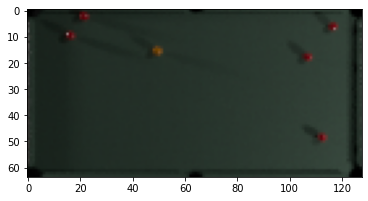

In [ ]:
plt.imshow(dataset[0]["image"])

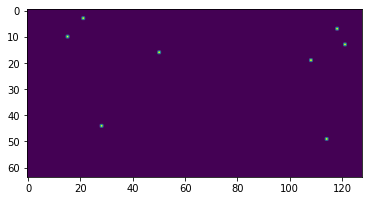

In [ ]:
target = dataset[0]["target"]
plt.imshow(target)

### DataLoader

In [ ]:
batch_size = 64
train_dataset = PoolImageDatasetSimplest(transforms=ToTen(),csv_file_path=csv_file_path,data_path = data_path,train = True)
test_dataset = PoolImageDatasetSimplest(transforms=ToTen(),csv_file_path=csv_file_path,data_path = data_path,train = False)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle = False,num_workers=2)

# Model building

Building a U-Net, you have to define different parts of the model.

As the name indicate, it's built in U shape. First you have to go down, using convolution and pooling. Then you go up and add previous states.

At the end, we do the contrary of the actual convolution

### Building convolution

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

### Building Down

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

### Building Up

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels) : #, bilinear=True):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

### Building the final convolution


In [ ]:
class FinalConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### Building the U-NET model


In [ ]:
class UNET(nn.Module):
  def __init__(self, n_channels, n_classes) -> None:
    super().__init__()

    self.n_channels = n_channels
    self.n_classes = n_classes


    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    self.down4 = Down(512, 1024)
    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)
    self.fconv = FinalConv(64, n_classes)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.fconv(x)
    
    return self.sig(logits)



# Setting-up the training

## Creating the model and the summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = UNET(3,1)
model.to(device)
summary(model, (3,64,128)) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 128]           1,728
       BatchNorm2d-2          [-1, 64, 64, 128]             128
              ReLU-3          [-1, 64, 64, 128]               0
            Conv2d-4          [-1, 64, 64, 128]          36,864
       BatchNorm2d-5          [-1, 64, 64, 128]             128
              ReLU-6          [-1, 64, 64, 128]               0
        DoubleConv-7          [-1, 64, 64, 128]               0
         MaxPool2d-8           [-1, 64, 32, 64]               0
            Conv2d-9          [-1, 128, 32, 64]          73,728
      BatchNorm2d-10          [-1, 128, 32, 64]             256
             ReLU-11          [-1, 128, 32, 64]               0
           Conv2d-12          [-1, 128, 32, 64]         147,456
      BatchNorm2d-13          [-1, 128, 32, 64]             256
             ReLU-14          [-1, 128,

## Hyperparameters

In [ ]:
lr = 1e-3
optimizer = SGD(model.parameters(),lr=lr)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)
epochs = 30

## Visualization setup


In [ ]:
!pip3 install wandb
import wandb

wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=900f1d4fb47325c0ab18f51867d4af95760fd8dcef98f4546502e960e427717d
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:

wandb.init(
      # Set the project where this run will be logged
      project="simplest_IA", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_w_Unet_V1", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": lr,
      "architecture": "U-NET",
      "dataset": "Blender_Dataset",
      "dataset_size" : 10000,
      "loss" : "BCELoss",
      "epochs": epochs,
      "batch_size": batch_size,

      })

wandb: Currently logged in as: sn00wden. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.watch(
    model,
    criterion = criterion,
    log = 'all',
    log_freq = 2
)

[]

# Training

## Step function

In [ ]:
def step(model: nn.Module, optim: torch.optim.Optimizer, criterion, loader: DataLoader, device: str = "cuda:0", train: bool = True) -> tuple[float, float] | float:


  avg_loss, avg_acc = 0.0, 0.0
  for sample in tqdm(loader):
      
      x, target = sample["image"].to(device), sample["target"].to(device)

      y_: torch.Tensor = model(x)

      loss = criterion(y_,target)

      if train:
          optim.zero_grad(set_to_none=None)
          loss.backward()
          optim.step()
      avg_loss += loss.item() / len(loader)

  return avg_loss

      


## Train loop

In [ ]:
def train(
    model: nn.Module,
    optim: torch.optim.Optimizer,
    criterion,
    train_loader: DataLoader,
    test_loader : DataLoader,
    device: str = "cuda:0",
    train: bool = True,
    epochs : int = 10
    ) -> None:
  best_loss = np.inf
  for i in tqdm(range(epochs)):

    # Train
    loss = step(model, optim, criterion, train_loader, train=True)
    wandb.log({"train_loss" : loss})

    # test
    loss = step(model,optim,criterion,test_loader,train = False)
    wandb.log({"test_loss" : loss})

    if loss < best_loss:
      best_loss = loss
      torch.save(model.state_dict(),"./best_unet_v1.txt")

## Let's train now 

In [ ]:
train(model,optim = optimizer,criterion = criterion,train_loader = train_dataloader, test_loader = test_dataloader, device="cuda:0", epochs=epochs)

 33%|███▎      | 10/30 [05:32<11:04, 33.24s/it]


KeyboardInterrupt: 

# Inference

## Validation set-up ################ NOT WORKING

#### Useful functions for testing and validation

In [ ]:
def verif_close(coords : np.ndarray, x,y) -> bool:
  eps = 2
  for i in range(len(coords[0])):
    if coords[0][i] == x:
      return True if coords[1][i] - eps <= y and coords[1][i] + eps >= y else False
    
    if coords[1][i] == x:
      return True if coords[0][i] - eps <= y and coords[0][i] + eps >= y else False


In [ ]:

def get_center(input : torch.Tensor, kernel_size : int = 4) -> torch :
  width = input.size()[2]
  height = input.size()[1]
  ret = torch.zeros(1,height,width,dtype=torch.float32)
  for y  in range(height):
    for x in range(width):
      temp_value = input[0,y,x]
      if temp_value !=0 :
        min_x= 0 if x-kernel_size < 0 else x -kernel_size
        min_y= 0 if y-kernel_size < 0 else y -kernel_size
        max_x = width-1 if x+kernel_size> width else x+kernel_size 
        max_y = height-1 if y+kernel_size> height else y+kernel_size 
        local_max = temp_value
        # modif = False
        for j in range(min_y,max_y):
          for i in range(min_x,max_x):
            if input[0,j,i] > local_max and i > 2:
              local_max = input[0,j,i]
              modif = True

        ret[0,y,x] = 1 if temp_value == local_max and x >2 and x< width -3 else 0.0
  return ret
            

In [ ]:
def extract_coords(input : torch.Tensor)-> np.darray:
  coords = [[],[]]
  width = input.size()[2]
  height = input.size()[1]

  for y in range(height):
    for x in range(width):
      if input[0,y,x] == 1 and not verif_close(coords,x,y):
        coords[0].append(x) # Append in list with x values
        coords[1].append(y) # Append in list with y values
  return np.array(coords)

In [ ]:


def mean_euclidian_distance(target_coords : np.ndarray, predict_coords : np.ndarray) -> np.ndarray :
  dist = []
  for x,y in zip(target_coords[0],target_coords[1]):
    dist_min = np.sqrt(np.power(x-predict_coords[0],2) + np.power(y-predict_coords[1],2))
    dist_min = np.min(dist_min) if len(dist_min) > 0 else 0 
    dist.append(dist_min)
  return (np.array(dist)).mean()

#### Final Valid function

In [ ]:
def valid(model : nn.Module, loader : DataLoader, device: str = "cuda:0", nb : int =  100, display : bool = False) -> float :
  mean_dist = 0.0
  nb_false_positive = 0.0
  nb_true_negative = 0.0
  # nb = nb_batch * batch_size

  y_ = None
  avg_loss, avg_acc = 0.0, 0.0
  start = time.time()
  for sample in loader:
    with torch.inference_mode() :

      x, target = sample["image"].to(device), sample["target"]
      y_: torch.Tensor = model(x)

      for _ in range(nb) :
        ind = random.randint(0,batch_size-1)

        thresh_function = torch.nn.Threshold(0.9,0,inplace = False)
        output_threshed = thresh_function(y_[ind])
        output_displayed = torch.squeeze(y_[ind],dim=1)
        to_pil = T.ToPILImage()

        f, axarr = plt.subplots(2,2)
        axarr[0,0].imshow(to_pil(output_displayed))
        axarr[0,0].title.set_text("Raw output")

        axarr[0,1].imshow(to_pil(output_threshed))
        axarr[0,1].title.set_text("Threshed output")
        # print(output_threshed.size())
        output_centered = get_center(output_threshed)
        # output_centered = torch.squeeze(output_centered,dim = 0)
        print("shape of tensor target", target[ind].shape)
        print("shape of tensor output", output_centered.shape)
        output_extracted, target_extracted= extract_coords(output_centered), extract_coords(target[ind])
        print("output_extracted : ", output_extracted)
        print("target_extracted : ", target_extracted)
        nb_false_positive += len(output_extracted) - len(target_extracted) if len(output_extracted) - len(target_extracted) >= 0 else  0.0
        nb_true_negative += -len(output_extracted) + len(target_extracted) if -len(output_extracted) + len(target_extracted) < 0 else  0.0

        # print(target_extracted)

        dist = mean_euclidian_distance(output_extracted, target_extracted)
        mean_dist += dist
        print(f"distance : {dist:.2e} Sw for one inference : {time.time() - start}")
        if display : 
          to_pil = T.ToPILImage()

          output_displayed = torch.squeeze(y_[ind],dim=1)
          f, axarr = plt.subplots(2,2)
          axarr[0,0].imshow(to_pil(output_displayed))
          axarr[0,0].title.set_text("Raw output")

          axarr[0,1].imshow(to_pil(output_threshed))
          axarr[0,1].title.set_text("Threshed output")

          axarr[1,0].imshow(to_pil(output_centered))
          axarr[1,0].title.set_text("Local maximum output")

          axarr[1,1].imshow(to_pil(target))
          axarr[1,1].title.set_text("Target")
      mean_dist /= nb
      nb_false_positive /= nb
      nb_true_negative /= nb
      print(f"\nMean distance of the valid ({nb} runs) : {mean_dist:.2e}")
      print(f"Number of false positive {nb_false_positive:.2e} | Number of true negative {nb_true_negative:.2e}")

      return mean_dist
      # break


## Validating 

### Import state dict of the trained model

In [ ]:
####################################### For testing purpose only #########################################
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNET(3,1)
model.load_state_dict(torch.load("/content/drive/MyDrive/Createch/Pool_Project/weights/best_2000_epochs.txt", map_location = torch.device(device)))
model.eval()
model.to(device)

RuntimeError: ignored

### Results

shape of tensor target torch.Size([1, 64, 128])
shape of tensor output torch.Size([1, 64, 128])
output_extracted :  []
target_extracted :  [[ 35  42  96 120  61  45]
 [  8  22  25  28  48  55]]
distance : nan Sw for one inference : 17.190488576889038


<ipython-input-82-e200e4c59be2>:7: RuntimeWarning: Mean of empty slice.
  return (np.array(dist)).mean()


ValueError: ignored

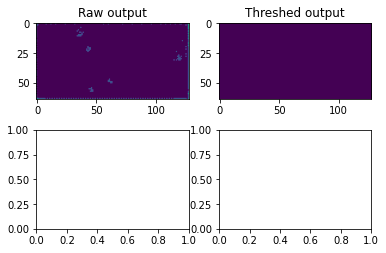

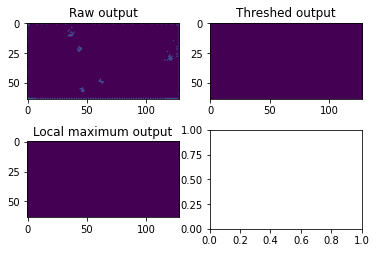

In [ ]:
test_valid = valid(model,test_dataloader,device = device,nb = 1, display = True)